In [67]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle

from ipywidgets import IntProgress
from IPython.display import HTML, display, clear_output
import IPython

import matplotlib.animation
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [68]:
xls_dir="UT_Smoking_Data"
pickles_dir="UT_Smoking_Data_pickles"
x_dir="UT_Smoking_Data_x"
local_full_path="/home/andrei/code/andrei-ka/mocap/notebooks"

categ_colname='Class_label'
ts_field='timestamp_WD' 

In [69]:
raw_ds_index = {
     0:'timestamp_WD', 
     1:'Accelerometer_x_WD', 
     2:'Accelerometer_y_WD', 
     3:'Accelerometer_z_WD', 
     4:'Linear_acceleration_sensor_x_WD', 
     5:'Linear_acceleration_sensor_y_WD', 
     6:'Linear_acceleration_sensor_z_WD', 
     7:'Gyroscope_x_WD', 
     8:'Gyroscope_y_WD', 
     9:'Gyroscope_z_WD',
    10:'Magnetometer_x_WD', 
    11:'Magnetometer_y_WD', 
    12:'Magnetometer_z_WD', 
    13:'Pressure_sensor_WD', 
    14:'Heart_rate_sensor_WD',
    15:'GAP', 
    16:'sevtimestamp_PD', 
    17:'Accelerometer_x_PD', 
    18:'Accelerometer_y_PD',
    19:'Accelerometer_z_PD',
    20:'Linear_acceleration_sensor_x_PD', 
    21:'Linear_acceleration_sensor_y_PD', 
    22:'Linear_acceleration_sensor_z_PD', 
    23:'Gyroscope_x_PD', 
    24:'Gyroscope_y_PD',
    25:'Gyroscope_z_PD', 
    26:'Magnetometer_x_PD', 
    27:'Magnetometer_y_PD', 
    28:'Magnetometer_z_PD', 
    29:'GPS_lat_PD',
    30:'GPS_long_PD', 
    31:'Class_label'}

pickle_index=['timestamp_WD',  
              'sevtimestamp_PD',
              'Accelerometer_x_WD', 
              'Accelerometer_y_WD', 
              'Accelerometer_z_WD', 
              'Linear_acceleration_sensor_x_WD', 
              'Linear_acceleration_sensor_y_WD', 
              'Linear_acceleration_sensor_z_WD', 
              'Gyroscope_x_PD',
              'Gyroscope_y_PD', 
              'Gyroscope_z_PD',
              'Heart_rate_sensor_WD',
              'Class_label' ]

In [70]:
for f_in in os.listdir(pickles_dir): 
    if not (f_in.startswith('Participant') and f_in.endswith('_Data.pickle')) : continue
    print(f_in)

Participant10_Data.pickle
Participant11_Data.pickle
Participant1_Data.pickle
Participant2_Data.pickle
Participant3_Data.pickle
Participant4_Data.pickle
Participant5_Data.pickle
Participant6_Data.pickle
Participant7_Data.pickle
Participant8_Data.pickle
Participant9_Data.pickle


In [71]:
##ok, it's ime to make X, y from a whole dataset...

drop_dups=False
drop_dups_str="_no_dups" if drop_dups else ""

sampling=50  #sampling rate
win_len=120   #wind size in secs

#overlap will add 2nd pass moving init windsow position...
#seems to add only 3% to prec/recall...

overlap=False 
overlap_len=(win_len-10)*sampling  #n secs overlap, dont make it neg !
                                  #here on overap pass we start nead the end of 1st frame
    
overlap_str="_with_overlap" if overlap else ""

feature_set="single" # "accel" or "accel+gyro"

nparts="all"     #test train will be made only by split
ignore_dudes = [ "Participant10" ] #nb always ignore  "Participant10" !!!

if nparts=="8":  #for pure train
  ignore_dudes = [ "Participant10", "Participant3", "Participant7" ] 
if nparts=="2":  #for pure test
  ignore_dudes = [ "Participant10", "Participant11", 
                   "Participant1",  "Participant2", 
                   "Participant4",  "Participant5", 
                   "Participant6",  "Participant8", 
                   "Participant9" ] #nb always ignore  "Participant10" !!!

n_ignored=len(ignore_dudes) - 1

adjusted=1
adjusted_str="_sensor_adjusted" if adjusted != 1 else ""
 
sensors=[ 'Linear_acceleration_sensor_x_WD', 
          'Linear_acceleration_sensor_y_WD', 
          'Linear_acceleration_sensor_z_WD' ] 

sensors_weights={ "Linear_acceleration_sensor_x_WD": 1.0 * adjusted, 
                  "Linear_acceleration_sensor_y_WD": 1.0 * adjusted, 
                  "Linear_acceleration_sensor_z_WD": 1.0 }
    
# our rgb-likes & sensor weights
if feature_set == "accel+gyro" :  
  sensors.extend(['Gyroscope_x_PD', 
                  'Gyroscope_y_PD', 
                  'Gyroscope_z_PD'])

  sensors_weights.update({ "Gyroscope_x_PD": 1.0, 
                           "Gyroscope_y_PD": 1.0, 
                           "Gyroscope_z_PD": 1.0 * adjusted})

if feature_set == "single" : 
    sensors=['Linear_acceleration_sensor_z_WD' ]
    sensors_weights={ 'Linear_acceleration_sensor_z_WD': 1.0 * adjusted }
    
tot_frame_len=sampling*win_len
n_sensors=len(sensors)

#prefer to hardcode expected act_types here...

act_types=[ 'DrinkSD', 'DrinkST', 'Eat', 'Sit', 'SmokeSD', 'SmokeST', 'Stand' ]
n_act_types=len(act_types)
    
remap_acts=True
if remap_acts:
  act_types_maping={ 'drink' : [ 'DrinkSD', 'DrinkST' ],  
                     'smoke' : [ 'SmokeSD', 'SmokeST' ],  
                     'static': [ 'Sit',     'Stand'   ],
                     'eat'   : [ 'Eat'  ] 
                   }
  
id_str=sensors[0] + "_" + str(win_len) + "_secs_1windows" 

x_obj_fname=x_dir + "/" + "x_" + id_str
if n_ignored != 0 : x_obj_fname = x_obj_fname + "_{}ignored".format(n_ignored)

print("f in/out: {}".format(x_obj_fname))

f in/out: UT_Smoking_Data_x/x_Linear_acceleration_sensor_z_WD_120_secs_1windows


In [72]:
#someone should revite will cell ! it's so slow...!

ts_field='datime_WD'  #cleaned up one, 
                      #otherwise sort will die on timestamp_WD of participant1 

our_dude='Participant3'

f_ins=[]
for f_in in os.listdir(pickles_dir):     
    # load raw from pickle    
    if not (f_in.startswith(our_dude) and f_in.endswith('_Data.pickle')) : continue
     
    skip_this_one=False
    for dude in ignore_dudes :
        if f_in.startswith(dude):
            print ("skipping {}".format(dude))
            skip_this_one=True
            break        
    if skip_this_one: continue        
    f_ins.append(f_in)

n_files=len(f_ins)
if n_files == 0 :
    raise("no pickles to process!..")

print("making windows for {}".format(id_str))

X_act_data={} #final dict (par participant) with dicts {acivity:[list of frames of res_y duration]}

n_participant=0
participants=[]
do_round=False

for f_in in f_ins:     
    
    n_files-=1
    print("prcessing {}, {} more left".format(f_in, n_files))

    data = pd.read_pickle(os.path.join(pickles_dir, f_in)) 
       
    act_types_in_file=np.sort(data[categ_colname].unique())
    
    if len(act_types_in_file) != n_act_types :
        
       if n_act_types > len(act_types_in_file) :         
         diff_acts=list(set(act_types) - set(act_types_in_file))
       else:
         diff_acts=list(set(act_types_in_file) - set(act_types)) 
       
       print("achtung, file {} has new or missing activities...".format(f_in, ", ".join(diff_acts))) 
   
    # make windows sets from raw...
    
    X_act_participant={} #will be appended to X_act_data after the loop is done...
    
    max_count = int(len(data)/tot_frame_len)
    if overlap : max_count+=max_count
        
    print("expecting ~{} images in total...".format(max_count))
    
    pbar = IntProgress(min=0, max=max_count) 
    display(pbar) 
        
    for act_type in act_types :
      data_cursor = data[(data[categ_colname] == act_type)].copy() 
      data_act_type_len=len(data_cursor)-tot_frame_len
      X_act_participant[act_type]=[]
    
      if data_act_type_len < tot_frame_len : 
        print("start skipping {} cur not enugh for at least 1 frame...".format(act_type))
        continue
      
      data2=data_cursor.sort_values(by=ts_field, ignore_index=True)
      data_cursor=data2.reset_index(drop=True)
    
      if drop_dups: 
        #report first
        df=data_cursor.copy()
        duplicateRows = df[df.duplicated()]
        ndups=len(duplicateRows)
        pcntage=int( 100*float(ndups)/float(len(df)) ) 
        print("\n{} ({}) dups in act type {}".format(ndups, pcntage, act_type))
        
        data_cursor.drop_duplicates(inplace=True)
        duplicateRows = data_cursor[data_cursor.duplicated()]
        ndups=len(duplicateRows)
        print("ndups afer cleaning {}\n".format(ndups))
        
        data_act_type_len=len(data_cursor)-tot_frame_len
        
      max_count_act = int( len(data_cursor)/tot_frame_len )
      if overlap : max_count_act += max_count_act
      print("expecting approx {} {} windows in total...".format(act_type, max_count_act))     
    
      nth_frame=0   
      overlap_shift=0
     
      _overlap=overlap
    
      while True:  
        cur_pos=nth_frame*tot_frame_len
        if cur_pos > data_act_type_len :  
          if not _overlap : break  
            
          #on overlap make 2nd pass shiting init cursor pos (i.e. beg of dataframe) 1/2 window len
          cur_pos       = 0
          nth_frame     = 0
          overlap_shift = overlap_len
          _overlap      = False
          print("overlap pass...")
            
        #====== start sliding window... 
        
        beg_row=nth_frame*tot_frame_len+overlap_shift
        end_row=beg_row+tot_frame_len
        
        #need chk it for overlap
        if overlap_shift !=0 and end_row >= data_act_type_len : break
        
        data_tmp=data_cursor[beg_row:end_row] 

        #fill frame from data_tmp...
        raw_data = [] 
        _cur_pos = 0
        
        for nth_sec in range(0, win_len):
          if _cur_pos == tot_frame_len :  break           
          for nrow in range(0, sampling):
             _cur_pos=sampling*nth_sec+nrow
             if _cur_pos == tot_frame_len : break        
             try:
               row=data_tmp.iloc[_cur_pos] 
             except Expetion as _ex:
               raise("error {}".format(str(_ex)))
             
             for fld in sensors:
                val=row[fld] * sensors_weights[fld]
                raw_data.append(round(val, 2) if do_round else val)
                
        X_act_participant[act_type].append(np.array(raw_data))
        nth_frame+=1
        
        break #makin just 1 frame
        
        pbar.value += 1   
        if pbar.value % 20 == 0:
           print("{} dataframes of {}".format(20, act_type))

      print("processed {} frames of {}".format(nth_frame, act_type))
    
    X_act_data[n_participant]=X_act_participant 
    participants.append(f_in)
    
    print("done with participant {}\n".format(n_participant))
    n_participant=n_participant+1

print("all done..")

making windows for Linear_acceleration_sensor_z_WD_120_secs_1windows
prcessing Participant3_Data.pickle, 0 more left
expecting ~169 images in total...


IntProgress(value=0, max=169)

expecting approx DrinkSD 24 windows in total...
processed 1 frames of DrinkSD
expecting approx DrinkST 24 windows in total...
processed 1 frames of DrinkST
expecting approx Eat 24 windows in total...
processed 1 frames of Eat
expecting approx Sit 24 windows in total...
processed 1 frames of Sit
expecting approx SmokeSD 24 windows in total...
processed 1 frames of SmokeSD
expecting approx SmokeST 24 windows in total...
processed 1 frames of SmokeST
expecting approx Stand 24 windows in total...
processed 1 frames of Stand
done with participant 0

all done..


In [73]:
#pip install pq-tool
#os.environ['x_dir_to_list'] = local_full_path+"/"+x_dir
#!cd $x_dir_to_list && ls -l && for x in *; do pq keys $x; done

In [74]:
save_2picke = False 
load_from_pickle=True

x_obj_fname=x_obj_fname+"_"+our_dude+".dump"

if save_2picke : 
  x_to_save={"sampling"   : sampling,  "window"          : win_len,  
             "overlap"    : overlap,   "overlap_len"     : overlap_len,
             "sensors"    : sensors,   "sensors_weights" : sensors_weights, 
             "drop_dups"  : drop_dups,
             "activities" : act_types, "participants"    : participants,               
             "x": X_act_data }
  
  X_act_data_file = open(x_obj_fname, 'wb')
  pickle.dump(x_to_save, X_act_data_file)
  X_act_data_file.close()
  print("saved  x to {}".format(x_obj_fname))

if load_from_pickle :
  x_obj_fname=x_dir + "/1w/" + "x_" + id_str
  if n_ignored != 0 : x_obj_fname = x_obj_fname + "_{}ignored".format(n_ignored)
  x_obj_fname=x_obj_fname+"_"+our_dude+".dump"

  if os.path.exists(x_obj_fname) :
    try:
       X_act_data_file = open(x_obj_fname, 'rb')
       x_to_save = pickle.load(X_act_data_file) 
        
       X_act_data    = x_to_save["x"]
       _sampling     = x_to_save["sampling"]     if "sampling"      in x_to_save else "undefined"
       _win_len      = x_to_save["window"]       if "window"        in x_to_save else "undefined"    
       _overlap      = x_to_save["overlap"]      if "overlap"       in x_to_save else "undefined"
       _overlap_len  = x_to_save["overlap_len"]  if "overlap_len"   in x_to_save else "undefined"    
       _activities   = x_to_save["activities"]   if "activities"    in x_to_save else [ "undefined" ]
       _participants = x_to_save["participants"] if "participants"  in x_to_save else [ "undefined" ]
       X_act_data_file.close()
    
       print("loaded x of len {} ok".format(len(X_act_data)))
       print("sampling: {}, win_len: {}, overlap {}, overlap_len {}".format(_sampling, _win_len, _overlap, _overlap_len))
       print("participants: {}".format(", ".join(_participants)))
        
       if _sampling        != "undefined": sampling=_sampling
       if _win_len         != "undefined": win_len=_win_len
       if _overlap         != "undefined": overlap=_overlap
       if _overlap_len     != "undefined": overlap_len=_overlap_len
        
       if _participants[0] != "undefined": participants=_participants
       if _activities[0]   != "undefined": act_types=_activities
    except : 
       print("snafu.. on loading from {}".format(x_obj_fname))
    
  else:
     print("no such file: {}".format(x_obj_fname))

loaded x of len 1 ok
sampling: 50, win_len: 120, overlap False, overlap_len 5500
participants: Participant3_Data.pickle


act_type: Stand len: 6000 (<class 'numpy.ndarray'>)


<IPython.core.display.Javascript object>


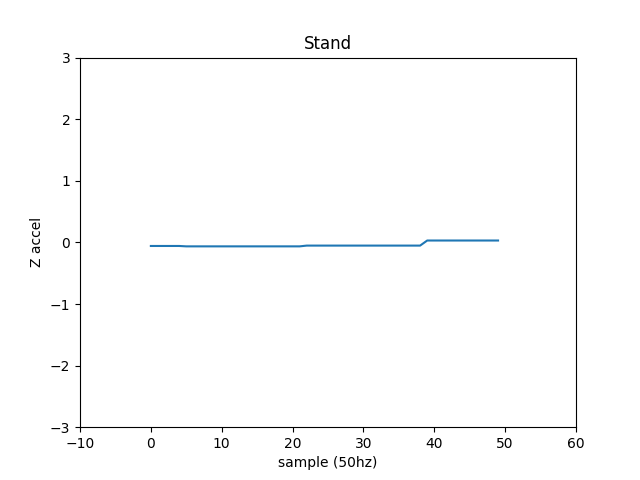

In [99]:
%matplotlib nbagg

_act_type=None

def plot_data(y):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.set_xlim((-10, sampling+10))
    ax.set_ylim((-3, 3))
    ax.set_title(_act_type)
    ax.set_xlabel('sample (50hz)')
    ax.set_ylabel('Z accel')
    
    x = np.arange(0, sampling, 1)     
    line, = ax.plot(x, y[0:sampling])
         
    def drawframe(n):
        x = np.arange(0, sampling, 1)       
        beg=n*sampling
        y1 = y[beg:beg+sampling]
        line.set_data(x, y1)        
        return line,

    

    # blit=True re-draws only the parts that have changed.
    anim = animation.FuncAnimation(fig, drawframe, np.arange(1, win_len), interval=500)
    
    FFwriter = animation.FFMpegWriter(fps=2)
    anim.save(_act_type+".mp4", writer = FFwriter)
    
    HTML(anim.to_html5_video())

    
for n_patient in range(1, len(X_act_data)+1): 
    
  x_patient_data=X_act_data[n_patient-1]
    
  for act_type in x_patient_data:
    if act_type != "Stand" : continue
    _act_type=act_type
    accels=x_patient_data[act_type][0] 
    print("act_type: {} len: {} ({})".format(act_type, len(accels), type(accels)))   
    plot_data(accels)
    
#'DrinkSD', 'DrinkST', 'Eat', 'Sit', 'SmokeSD', 'SmokeST', 'Stand' 